In [1]:
import requests

In [2]:
payload = {
    "prompt": "maltese puppy",
    "steps": 5
}

response = requests.post(url=f'http://127.0.0.1:7860/sdapi/v1/txt2img', json=payload)

In [3]:
response.text

'{"detail":"Not Found"}'

In [2]:
import json
import requests
import io
import base64
from PIL import Image, PngImagePlugin

url = "http://127.0.0.1:7860"

payload = {
    "prompt": "puppy dog",
    "steps": 5
}

response = requests.post(url=f'{url}/sdapi/v1/txt2img', json=payload)

r = response.json()

for i in r['images']:
    image = Image.open(io.BytesIO(base64.b64decode(i.split(",",1)[0])))

    png_payload = {
        "image": "data:image/png;base64," + i
    }
    response2 = requests.post(url=f'{url}/sdapi/v1/png-info', json=png_payload)

    pnginfo = PngImagePlugin.PngInfo()
    pnginfo.add_text("parameters", response2.json().get("info"))
    image.save('output.png', pnginfo=pnginfo)


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=7860): Max retries exceeded with url: /sdapi/v1/txt2img (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe38dbf0820>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [10]:
import base64
import requests

url = "http://127.0.0.1:7860"

payload = {
    "prompt": "puppy dog",
    "steps": 40,
    "batch_size": 2
}

# request the image generation from the backend
response = requests.post(f'{url}/sdapi/v1/txt2img', json=payload)
if not response.ok:
    raise RuntimeError("post request failed")

# write each file to disk
for i, base64_image in enumerate(response.json()['images']):
    # attention: the API does return the file type set in the backend options
    #   trusting it to be always png will go wrong eventually
    with open(f'output{i}.png', 'wb') as fp:
        fp.write(base64.b64decode(base64_image))

In [11]:
response.text

'{"images":["iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAAA2HRFWHRwYXJhbWV0ZXJzAHB1cHB5IGRvZwpTdGVwczogNDAsIFNhbXBsZXI6IEV1bGVyLCBDRkcgc2NhbGU6IDcuMCwgU2VlZDogMjY1MDMyODUyNywgU2l6ZTogNTEyeDUxMiwgTW9kZWwgaGFzaDogYzZiYmMxNWUzMiwgTW9kZWw6IHNkLXYxLTUtaW5wYWludGluZywgRGVub2lzaW5nIHN0cmVuZ3RoOiAwLCBDb25kaXRpb25hbCBtYXNrIHdlaWdodDogMS4wLCBWZXJzaW9uOiB2MS42LjC0/CFZAAEAAElEQVR4nET9y64kS9M2CNnJ3SMiV9XeX6O+J2YIaDFATJBaIFpISD0AfgYIiRkj7rOl791VKzPC3Y4MvN6fGpRUWqWVmZF+MHtOhv/f/8//6LqyiITLA7EAKdyls2sQSWRWBSIwt6wKDybMCBIW4Xk//RhZpUtbb4Bgy4goq0YXc5U23CzLEZmZIwOSTJeIIMLxOuc9AUGY57P6MaDSIwkl3LnxvNfxOhjJLCwCKqQJESECkeg0IoYMDf3759/3nAjl5q23CJfWERCJdGkTJoaMRGYAzEiAQgQRySJ3z0yCOq4RHoikZuGBhMzAxABYUABIWIgQ4X0Ms0BkDy8PaS0jEAmxCtI9UZgJoKCqwjwrxnG4OwtXIkCFeUFJExYRaZ/3k+Gv12m6SJhbN3PIBKhC0qXncTxTRVqGR/pxHFWly90WN2ZmM+fWwhyqWISRzJOYTJ9xjAxAJjcPdyQQYUAkBCC53+/rPOb8tD6yilu3ZbrWGL2Qem/uDgWAaWtxa+d5LDXIMl8iLaNaFzfr43w+d0EhEZMAYkQQAiImAGQgYBt9PpOlu7uIVBYSIKDbaq15lKqO0ZFApKtqerTRzAwBpTdbswpEhJgiEhFNVUQikpmrysz7aFUJQKp

In [5]:
import base64
import requests

import numpy as np
import os

from PIL import Image, PngImagePlugin
import cv2

In [6]:
url = "http://127.0.0.1:7860"

In [ ]:
def load_img_to_array(img_p):
    img = Image.open(img_p)
    img = img.convert("RGB")
    return np.array(img)

def to_b64(img):
    jpg_img = cv2.imencode('.png', img)
    b64_string = base64.b64encode(jpg_img[1]).decode("utf-8")
    return b64_string

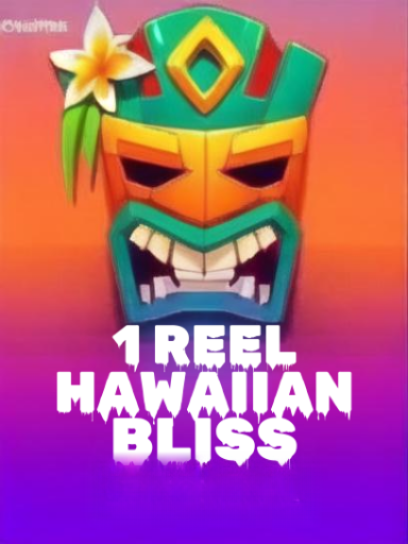

In [15]:
orig_img = load_img_to_array("/home/jjjj/Pictures/7_09_without_prov/1 Reel Hawaiian Bliss0.png")
Image.fromarray(orig_img)

In [16]:
a = np.array(Image.fromarray(orig_img).convert("L"))


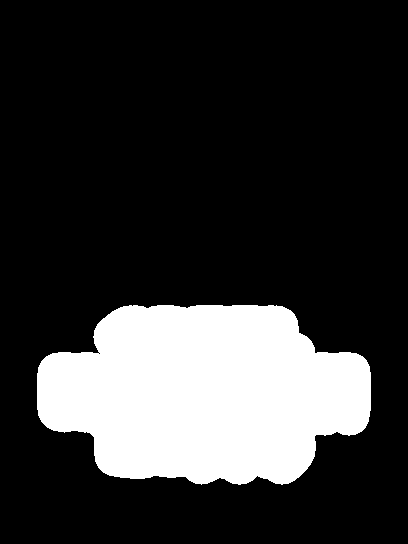

In [17]:
blured = cv2.GaussianBlur(a, (1,1), cv2.BORDER_DEFAULT)


mask = np.zeros([orig_img.shape[0], orig_img.shape[1]],dtype=np.uint8)
mask[310:][blured[310:] > 195] = 255


cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    cv2.drawContours(mask, [c], -1, 255, thickness=40)


Image.fromarray(mask)

In [18]:
payload = {
    "prompt": "",
    "steps": 40,
    "batch_size": 6,
    "include_init_images": True,
    "mask": to_b64(mask),
    "init_images": [
        to_b64(orig_img)
    ],
    "inpainting_fill": 2
}

In [19]:
a = requests.get(f'{url}/sdapi/v1/options').json()
a

{'samples_save': True,
 'samples_format': 'png',
 'samples_filename_pattern': '',
 'save_images_add_number': True,
 'grid_save': True,
 'grid_format': 'png',
 'grid_extended_filename': False,
 'grid_only_if_multiple': True,
 'grid_prevent_empty_spots': False,
 'grid_zip_filename_pattern': '',
 'n_rows': -1.0,
 'font': '',
 'grid_text_active_color': '#000000',
 'grid_text_inactive_color': '#999999',
 'grid_background_color': '#ffffff',
 'enable_pnginfo': True,
 'save_txt': False,
 'save_images_before_face_restoration': False,
 'save_images_before_highres_fix': False,
 'save_images_before_color_correction': False,
 'save_mask': False,
 'save_mask_composite': False,
 'jpeg_quality': 80.0,
 'webp_lossless': False,
 'export_for_4chan': True,
 'img_downscale_threshold': 4.0,
 'target_side_length': 4000.0,
 'img_max_size_mp': 200.0,
 'use_original_name_batch': True,
 'use_upscaler_name_as_suffix': False,
 'save_selected_only': True,
 'save_init_img': False,
 'temp_dir': '',
 'clean_temp_dir_a

In [20]:
models = requests.get(f'{url}/sdapi/v1/sd-models').json()

In [21]:
models

[{'title': '512-inpainting-ema.safetensors',
  'model_name': '512-inpainting-ema',
  'hash': None,
  'sha256': None,
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/Stable-diffusion/512-inpainting-ema.safetensors',
  'config': None},
 {'title': 'absolutereality_v181INPAINTING.safetensors',
  'model_name': 'absolutereality_v181INPAINTING',
  'hash': None,
  'sha256': None,
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/Stable-diffusion/absolutereality_v181INPAINTING.safetensors',
  'config': None},
 {'title': 'abyssorangemix2NSFW_abyssorangemix2Nsfw-inpainting.safetensors',
  'model_name': 'abyssorangemix2NSFW_abyssorangemix2Nsfw-inpainting',
  'hash': None,
  'sha256': None,
  'filename': '/home/jjjj/Documents/stable-diffusion-webui/models/Stable-diffusion/abyssorangemix2NSFW_abyssorangemix2Nsfw-inpainting.safetensors',
  'config': None},
 {'title': 'clarity_V3-inpainting.safetensors',
  'model_name': 'clarity_V3-inpainting',
  'hash': None,
  'sha2

In [22]:
MODELS = {i['title'].split(" ")[0]: i['title'] for i in models} 

In [23]:
'sd-v1-5-inpainting.ckpt [c6bbc15e32]'

'sd-v1-5-inpainting.ckpt [c6bbc15e32]'

In [24]:
new_options = {}
new_options['sd_model_checkpoint'] = 'sd-v1-5-inpainting.ckpt [c6bbc15e32]'

In [25]:
new_options

{'sd_model_checkpoint': 'sd-v1-5-inpainting.ckpt [c6bbc15e32]'}

In [26]:
payload = {
    "prompt": "mask",
    "negative_prompt": "logo, text",
    "steps": 40,
    "batch_size": 6,
    "include_init_images": True,
    "mask": to_b64(mask),
    "init_images": [
        to_b64(orig_img)
    ],
    "inpainting_fill": 0,
    "override_settings": new_options
}

In [27]:
response = requests.post(f'{url}/sdapi/v1/img2img', json=payload)
if not response.ok:
    raise RuntimeError("post request failed")

# write each file to disk
for i, base64_image in enumerate(response.json()['images']):
    # attention: the API does return the file type set in the backend options
    #   trusting it to be always png will go wrong eventually
    with open(f'123output__{i}.png', 'wb') as fp:
        fp.write(base64.b64decode(base64_image))

In [34]:
import io

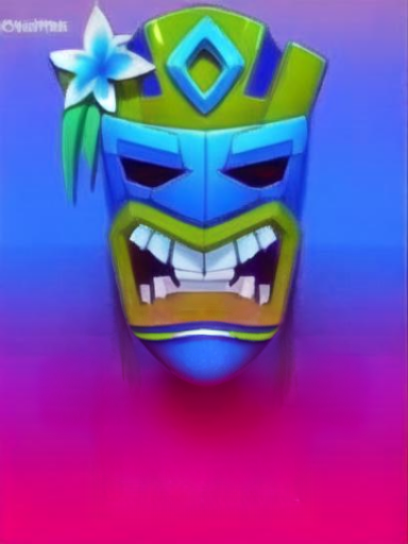

In [44]:
a["filter_nsfw"]

KeyError: 'filter_nsfw'

In [40]:
# request the image generation from the backend
response = requests.post(f'{url}/sdapi/v1/img2img', json=payload)
if not response.ok:
    raise RuntimeError("post request failed")

# write each file to disk
for i, base64_image in enumerate(response.json()['images']):
    # attention: the API does return the file type set in the backend options
    #   trusting it to be always png will go wrong eventually
    with open(f'output__{i}.png', 'wb') as fp:
        fp.write(base64.b64decode(base64_image))

In [2]:
import numpy as np

In [3]:
def load_img_to_array(img_p):
    img = Image.open(img_p)
    img = img.convert("RGB")
    return np.array(img)

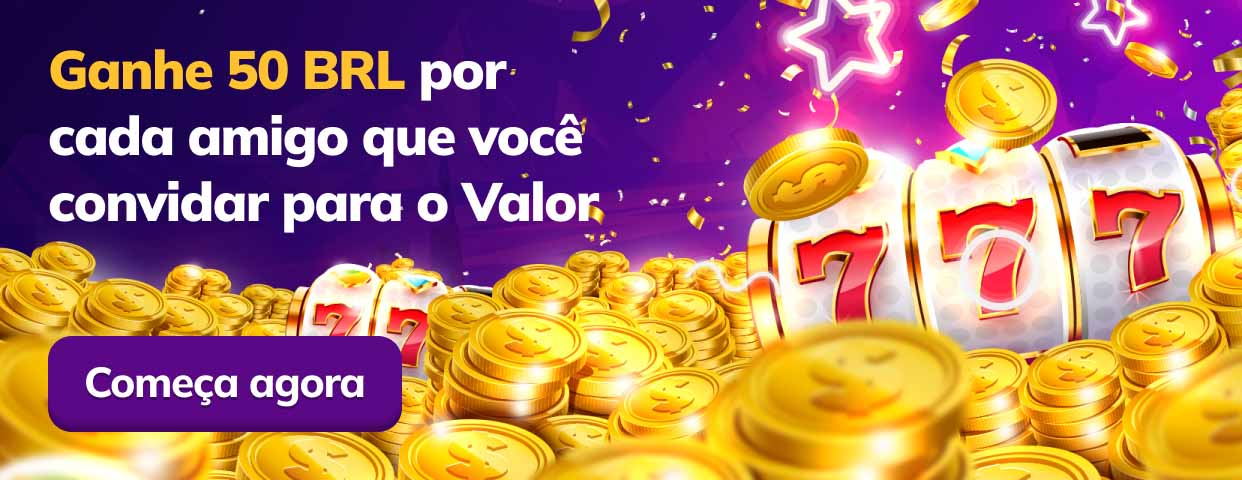

In [30]:
orig_img = load_img_to_array("/home/jjjj/Documents/gallery_view/data_test/Mobile_Low/02X_Brazil_x3_Low.jpg")
Image.fromarray(orig_img)

In [31]:
orig_img.shape

(480, 1242, 3)

In [32]:
h, w = 288, 1194
h, w

(288, 1194)

In [33]:
if orig_img.shape[0] > h or orig_img.shape[1] > w:
    percentage = min(w / orig_img.shape[1], h / orig_img.shape[0])
percentage

0.6

In [34]:
new_w = int(percentage * orig_img.shape[1])
new_h = int(percentage * orig_img.shape[0])
new_h, new_w

(288, 745)

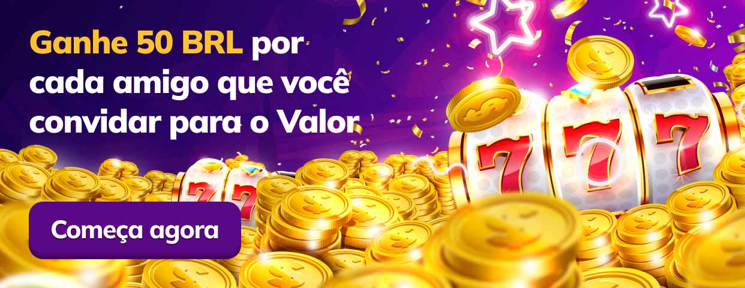

In [35]:
orig_img = Image.fromarray(orig_img).resize((new_w, new_h), reducing_gap=3)
orig_img

In [36]:
orig_img = np.array(orig_img)

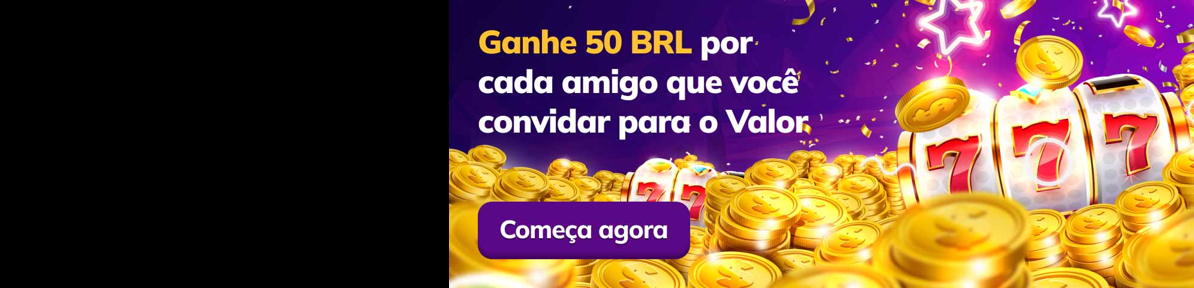

In [51]:
left = False
top = True
right = True
bottom = True

n = 5

new_img = np.zeros([h, w, 3],dtype=np.uint8)

if top != bottom:
    top = 0 if top else new_img.shape[0] - orig_img.shape[0]
    bottom = new_img.shape[0] if bottom else orig_img.shape[0]
if right != left: 
    left = 0 if left else new_img.shape[1] - orig_img.shape[1]
    right = new_img.shape[1] if right else orig_img.shape[1]

if right == left:
    left = (new_img.shape[1] - orig_img.shape[1]) // 2
    right = left + orig_img.shape[1]
if top == bottom:
    top = (new_img.shape[0] - orig_img.shape[0]) // 2    
    bottom = top + orig_img.shape[0]

new_img[top:bottom, left:right, :] = orig_img
# masked_img = np.zeros([480, 1242, 3],dtype=np.uint8)
# masked_img[:img.shape[0] - n, :img.shape[1] - n, :] = img[:-n, :-n, :]
# mask = ((new_img == (0, 0, 0)).astype(int) * 255)[:, :, 0]
Image.fromarray(new_img)

In [49]:
n = 15
mask = np.ones([new_img.shape[0], new_img.shape[1], 3],dtype=np.uint8) * 255
mask[top+n:bottom-n, left+n:right-n, :] = 0

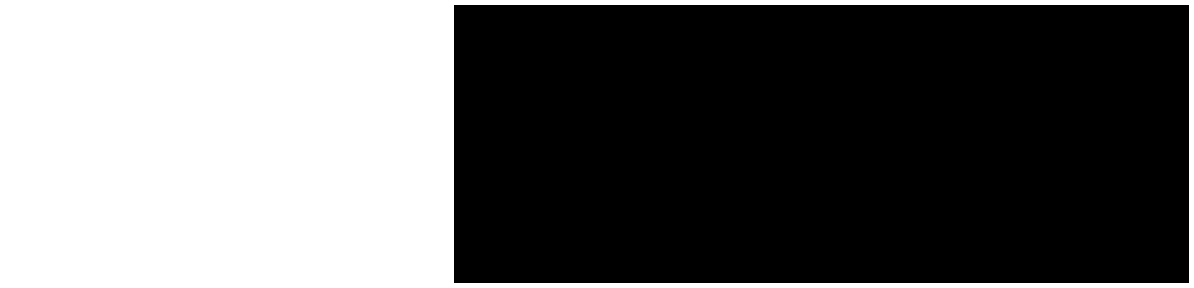

In [50]:
Image.fromarray(mask.astype(np.uint8))

In [45]:
type(mask)

numpy.ndarray

In [15]:
def get_mask_img(img, left, top, right, bottom, n=10):
    new_img = np.zeros([480, 1242, 3],dtype=np.uint8)
    new_img[:img.shape[0], :img.shape[1], :] = img
    masked_img = np.zeros([480, 1242, 3],dtype=np.uint8)
    masked_img[:img.shape[0] - n, :img.shape[1] - n, :] = img[:-n, :-n, :]
    mask = ((masked_img == (0, 0, 0)).astype(int) * 255)[:, :, 0]
    return new_img, mask

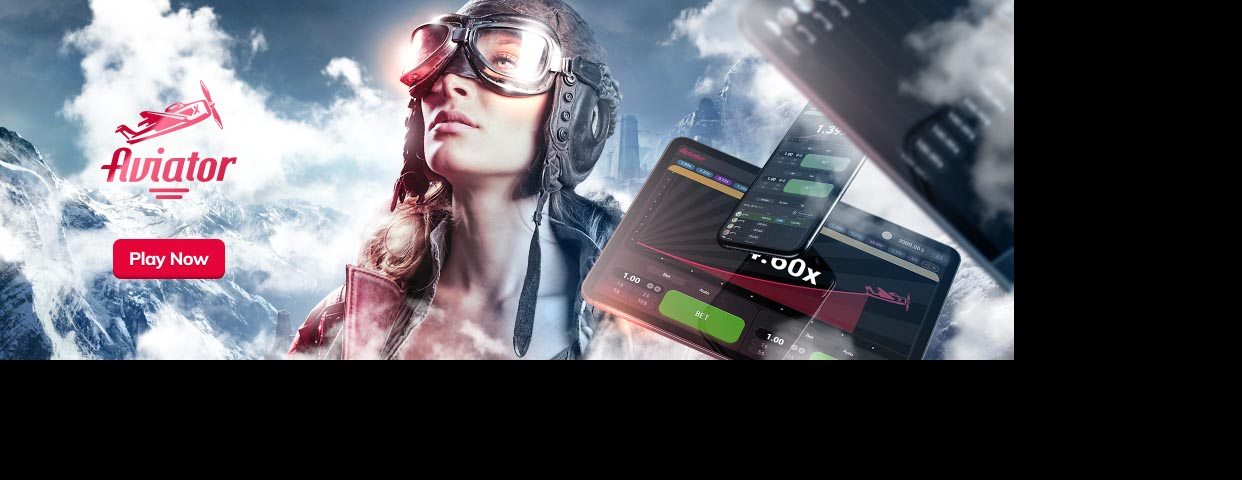

In [16]:
i, m = get_mask_img(orig_img, False, False, False, False)
Image.fromarray(i)

In [18]:
left, top, right, bottom = True, True, False, False

In [20]:
h, w = 480, 1242

In [19]:
new_img = np.zeros([480, 1242, 3],dtype=np.uint8)

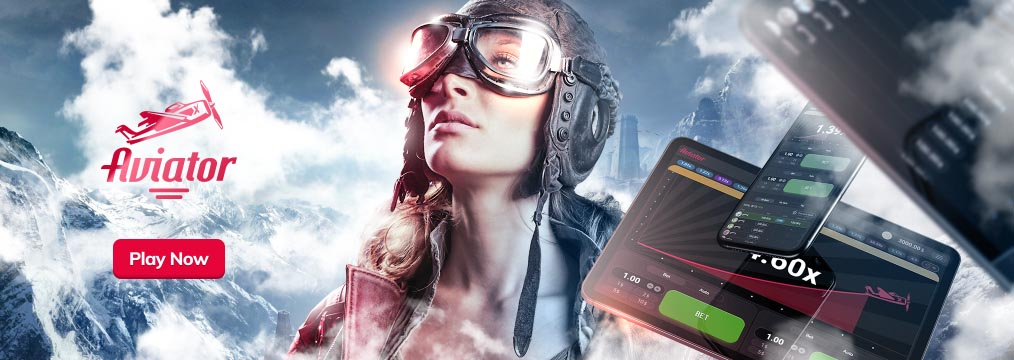

In [28]:
orig_img = load_img_to_array("/home/jjjj/Documents/gallery_view/data_test/Desktop_Med/07D_India_x1_Med.jpg")
Image.fromarray(orig_img)

In [30]:
orig_img.shape

(360, 1014, 3)

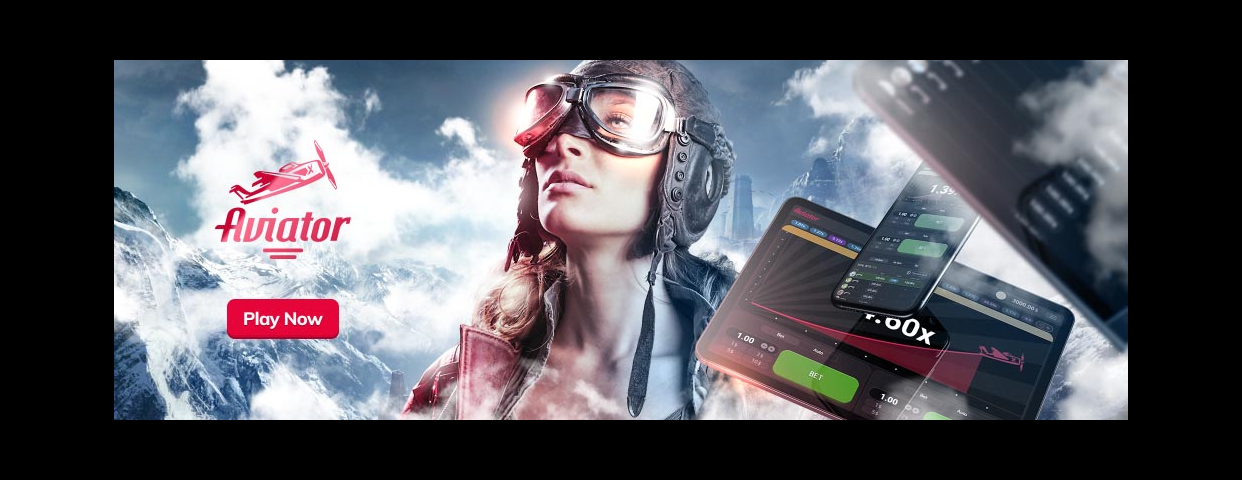

In [42]:
left = True
top = True
right = True
bottom = True

n = 10

new_img = np.zeros([480, 1242, 3],dtype=np.uint8)

if top != bottom:
    top = 0 if top else new_img.shape[0] - orig_img.shape[0]
    bottom = new_img.shape[0] if bottom else orig_img.shape[0]
if right != left: 
    left = 0 if left else new_img.shape[1] - orig_img.shape[1]
    right = new_img.shape[1] if right else orig_img.shape[1]

if right == left:
    left = (new_img.shape[1] - orig_img.shape[1]) // 2    
    right = left + orig_img.shape[1]
if top == bottom:
    top = (new_img.shape[0] - orig_img.shape[0]) // 2    
    bottom = top + orig_img.shape[0]

new_img[top:bottom, left:right, :] = orig_img
# masked_img = np.zeros([480, 1242, 3],dtype=np.uint8)
# masked_img[:img.shape[0] - n, :img.shape[1] - n, :] = img[:-n, :-n, :]
# mask = ((masked_img == (0, 0, 0)).astype(int) * 255)[:, :, 0]
Image.fromarray(new_img)

In [ ]:
mask

In [37]:
top, bottom

(360, 480)

In [36]:
right - 228

1014

In [ ]:
new_img[:img.shape[0], :img.shape[1], :] = img

In [39]:
orig_img.shape

(360, 1014, 3)

In [ ]:
# 1242 х 480

In [50]:
new_img = np.zeros([480, 1242, 3],dtype=np.uint8)

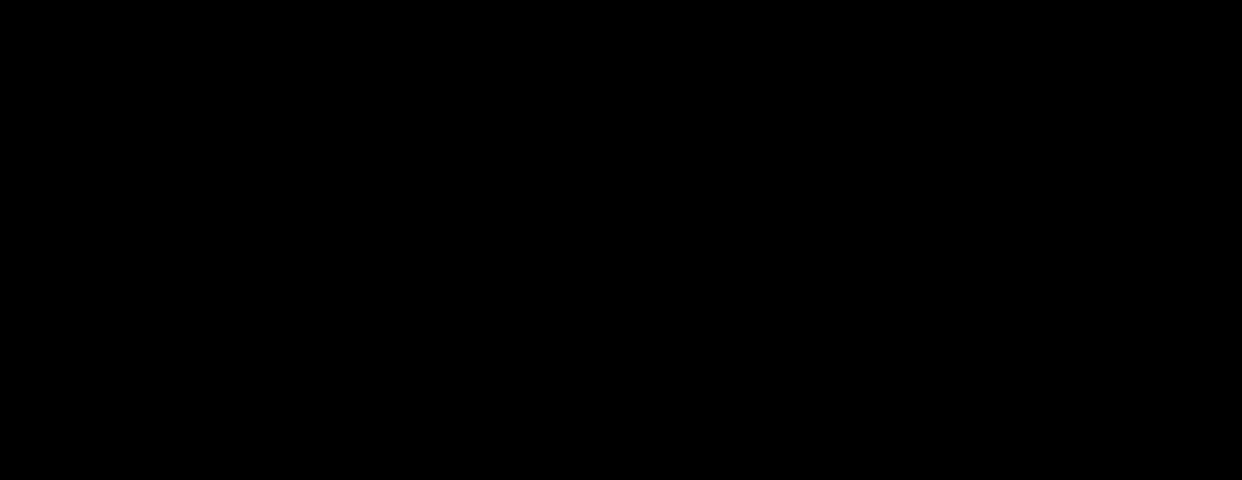

In [51]:
Image.fromarray(new_img)

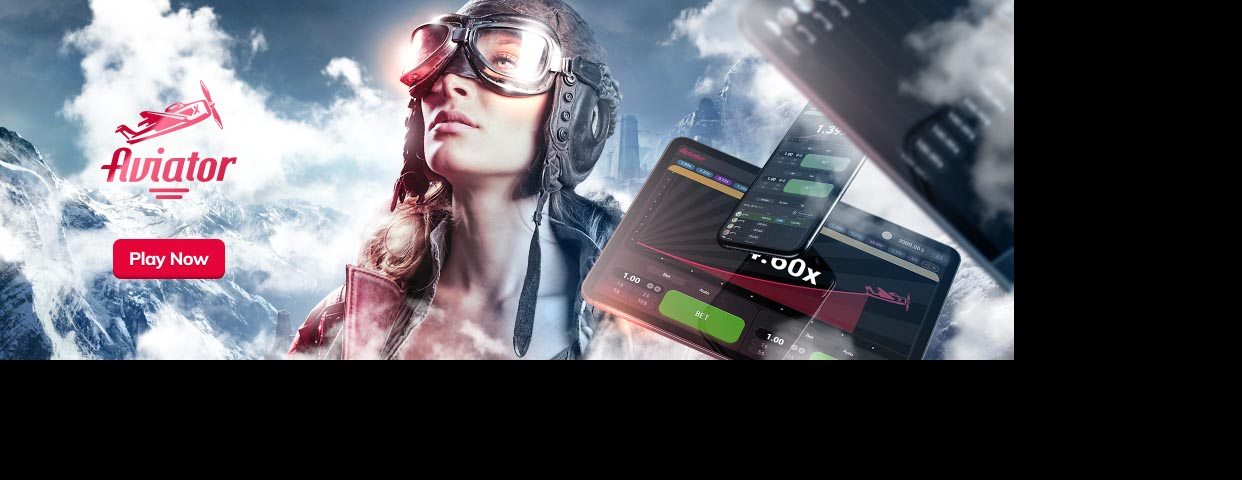

In [52]:
new_img[:orig_img.shape[0], :orig_img.shape[1], :] = orig_img
Image.fromarray(new_img)

In [53]:
mask = 

SyntaxError: invalid syntax (3677105236.py, line 1)

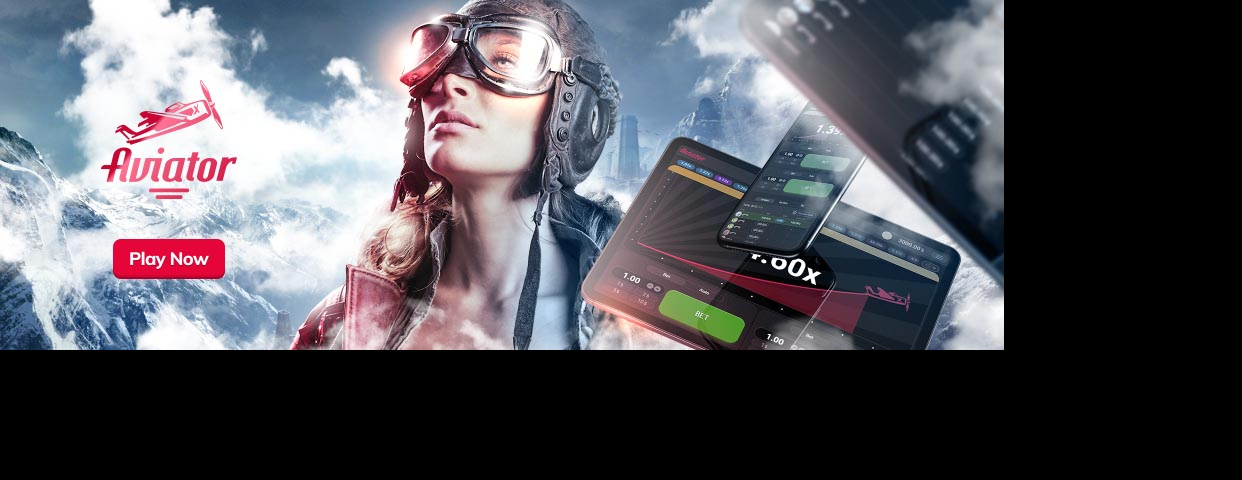

In [64]:
n = 10
masked_img = np.zeros([480, 1242, 3],dtype=np.uint8)
masked_img[:orig_img.shape[0] - n, :orig_img.shape[1] - n, :] = orig_img[:-n, :-n, :]
Image.fromarray(masked_img)

In [65]:
mask = ((masked_img == (0, 0, 0)).astype(int) * 255)[:, :, 0]
mask.shape

(480, 1242)

In [66]:
def get_models():
    return [i['title'] for i in requests.get(f'{url}/sdapi/v1/sd-models').json()]

In [81]:
get_models()

['512-inpainting-ema.safetensors',
 'absolutereality_v181INPAINTING.safetensors [7e16c94105]',
 'abyssorangemix2NSFW_abyssorangemix2Nsfw-inpainting.safetensors',
 'clarity_V3-inpainting.safetensors',
 'deliberate_v3-inpainting.safetensors [cadc1eef6f]',
 'dreamshaper_7-inpainting.safetensors [73903a3bad]',
 'dreamshaper_8Inpainting.safetensors',
 'experience_70-inpainting.safetensors [67b7918e20]',
 'galaxytimemachinesGTM_v5.safetensors',
 'icbinpICantBelieveIts_secoInpainting.safetensors',
 'lofi_v3Inpaint.safetensors [9c8555b197]',
 'meinaunreal_v41-inpainting.safetensors',
 'mistoonAnime_v20Inpainting.safetensors [c77c3c7c15]',
 'neverendingDreamNED_v122-inpainting.safetensors [a62b4ac3a2]',
 'realisticVisionV51_v51VAE-inpainting.safetensors [f0d4872d24]',
 'revAnimated_v121Inp-inpainting.safetensors',
 'sd-v1-5-inpainting.ckpt [c6bbc15e32]',
 'v1-5-pruned-emaonly.safetensors [6ce0161689]',
 'vae-ft-mse-840000-ema-pruned.safetensors']

In [77]:
def to_b64(img):
    img = np.array(img)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    jpg_img = cv2.imencode('.png', img)
    b64_string = base64.b64encode(jpg_img[1]).decode("utf-8")
    return b64_string

In [78]:
model = "experience_70-inpainting.safetensors"

In [82]:
for m in get_models():
    payload = {
        "prompt": "aviator",
        "negative_prompt": "",
        "steps": 40,
        "batch_size": 1,
        "include_init_images": True,
        "mask": to_b64(mask),
        "init_images": [
            to_b64(new_img)
        ],
        "inpainting_fill": 0,
        "override_settings": {
            "sd_model_checkpoint": model
        }
    }
    
    response = requests.post(f'{url}/sdapi/v1/img2img', json=payload)
    Image.open(io.BytesIO(base64.b64decode(response.json()["images"][0]))).save(m + "img.png")

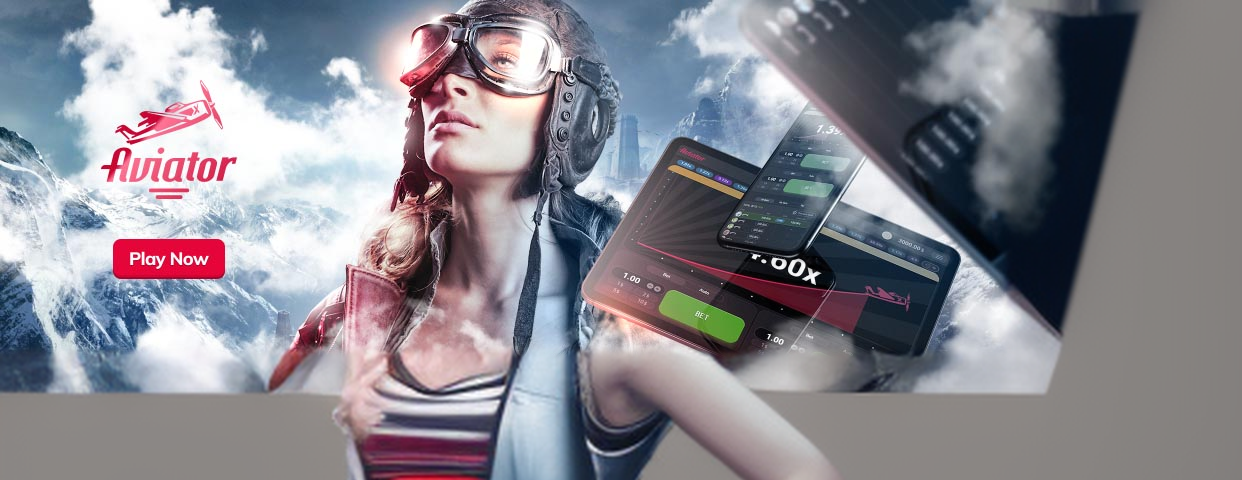

In [80]:
mask.shape

(480, 1242)